# MORPHOLOGY TEST

In [1]:
import numpy as np
from matplotlib import pyplot, cm
from neuron import h, gui
from neuron.units import mV, ms, sec, um

%matplotlib inline
# c compiler
#!nrnivmodl vecevent.mod

In [2]:
def createSynapse(dendIdx, loc=0.5, tau=[2*ms, 4*ms], e=0*mV):
    """Creates an excitatory synapse on the dendrite given by Idx."""
    syn = h.Exp2Syn(dend[dendIdx](loc))
    syn.tau1 = tau[0]
    syn.tau2 = tau[1]
    syn.e = e
    return syn 

def createStim(isi=20*ms, num=100, start=1*ms, noise=1, seed=9):
    stim = h.NetStim()
    stim.interval = isi
    stim.number = num
    stim.start = start
    stim.noise = noise
    stim.noiseFromRandom123(seed, 0, 0)
    stim.seed(seed)
    
    return stim

def connectStim(syn, stim, delay=1*ms, weight=0.4):
    conn = h.NetCon(stim, syn)
    conn.delay = delay
    conn.weight[0] = weight
    
    return conn

def createStim(isi=20*ms, num=100, start=1*ms, noise=1, seed=9):
        stim = h.NetStim()
        stim.interval = isi
        stim.number = num
        stim.start = start
        stim.noise = noise
        stim.noiseFromRandom123(seed, 0, 0)
        stim.seed(seed)
        return stim

def homogeneous_poisson(rate, tmax, bin_size):
    "Rate in Hz, Tmax and bin_size in ms"
    
    nbins = np.floor(tmax/bin_size).astype(int)
    
    prob_of_spike = rate * bin_size / 1e3 #In ms^-1
    
    spikes = np.random.rand(nbins) < prob_of_spike
    
    return spikes * 1

def Background_noise(rate,bin_size,tmax,numInputs):

    BoolTS = homogeneous_poisson(rate, tmax, bin_size)
    
    return [np.where(BoolTS==1)[0]*bin_size for i in range(numInputs)],BoolTS

def CreateVecStim(numInputs,tmax,rate=10,bin_size=0.1):

    Noise,BoolTS = Background_noise(rate,bin_size,tmax,numInputs)

    stimulations = [h.VecStim() for i in range(numInputs)]

    Noivec = [h.Vector(Noise[i]) for i in range(numInputs)]

    for i in range(numInputs):
        
        stimulations[i].play(Noivec[i])
    
    return stimulations,Noise,BoolTS

np.random.seed(12345)


In [3]:

def CorrInputs(tmax,rate,Nsour=2,bin_size=2.5,a=0,b=0):
    
    Noiseb,BoolTS = Background_noise(rate,bin_size,tmax,1)
    
    NoiseCorr = []
    
    NoiseCorr.append(np.int32(np.round(Noiseb[0])))
    
    for i in range(Nsour-1):

        DerI = np.int32(np.round(Noiseb[0] + np.random.normal(a,b,len(Noiseb))))

        #Inputs should be inside the simulation time interval
        DerI *= 1*(DerI >= 0)*(DerI < tmax)

        #Delete inputs at 0 s
        DerI = [i for i in DerI if i!=0]

        NoiseCorr.append(np.array(DerI))
    
    stimulationsSour = [h.VecStim() for i in range(Nsour)]

    NoivecS = [h.Vector(NoiseCorr[i]) for i in range(Nsour)]

    for i in range(Nsour):
        
        stimulationsSour[i].play(NoivecS[i])
    
    return stimulationsSour,NoiseCorr,BooleanInputInfo(NoiseCorr,tmax,bin_size,numSour)

def BooleanInputInfo(NoiseCorrt,tmax,bin_size,numSour):
    
    St = np.arange(0,tmax,bin_size)

    Sbool = np.zeros([numSour,St.shape[0]],dtype=np.int8)

    for i in range(len(NoiseCorrt)):

        for j in NoiseCorrt[i]:

            Sbool[i,np.where(St==j)] = 1
    
    return Sbool

def EI_Synaptic_info(numNoiseInputs,tauE,tauI):
    
    pp = [0.8,0.2]

    es = [0,-80]

    ee = np.random.choice(es,numNoiseInputs,p=pp)

    tau = np.zeros([ee.shape[0],2])

    tau[np.where(ee<0)] = tauI
    tau[np.where(ee>=0)] = tauE
    
    return ee,tau


In [4]:
h.nrn_load_dll("x86_64/vecevent.so")

0.0

In [5]:

filename = "DATA/Pyrp22.hoc"

h.load_file(filename) 

allsec = h.allsec()

dend = [s for s in allsec if s.name().startswith('dend')]


In [6]:
#INITIALIZE PARAMETERS

Vrest = -70*mV

# membrane properties are defined here */
membranecap = 0.638856    # specific membrane capacitance in uF cm^-2 */
membraneresist = 120236.0 # specific membrane resistance in ohm cm^2 */
axialresist = 141.949     # axial resistivity in ohm cm */

# dend sections
dend = [s for s in allsec if s.name().startswith('dend')]

for sec in dend:
    
    sec.insert('pas')
    sec.e_pas=Vrest
    sec.g_pas = 5.34/membraneresist
    
    sec.Ra = axialresist
    sec.cm = 5.34*membranecap

Soma = [s for s in allsec if s.name().startswith('soma')]

for sec in Soma:

    sec.insert('hh')
    
    sec.Ra = axialresist
    sec.cm = 1.0*membranecap

    for seg in sec:
        seg.hh.gnabar = 0.12  # Sodium conductance in S/cm2
        seg.hh.gkbar = 0.036  # Potassium conductance in S/cm2
        seg.hh.gl = 0.0003    # Leak conductance in S/cm2
        seg.hh.el = -54.3     # Reversal potential in mV


In [7]:
import pandas as pd

List = pd.read_csv("DATA/Section_List.csv")

filename = "DATA/Pyrp22.hoc"

h.load_file(filename) 

allsec = h.allsec()

dend = [s for s in allsec if s.name().startswith('dend')]

#SELECTING SECTION FOR BACKGROUND NOISE

def Select_Noise_sections(List,dend,Cell="Pyrp22",rangeL=[0,1500],numNoiseInputs=100):
    
    Cell0 = List[(List['Cell']==Cell)&(List['Names'].str.contains("dend"))]

    #For background noise
    rangeL = [0,1500]

    SecNames = Cell0[(Cell0['L']>rangeL[0])&(Cell0['L']<rangeL[1])].Names.values

    dendIdx0 = []

    for i in range(len(dend)):
        sec = dend[i]
        if str(sec) in SecNames:
            dendIdx0.append(i)
    
    dendIdx = np.random.choice(dendIdx0,numNoiseInputs)
    
    return dendIdx

#SELECTING SECTION FOR INPUTs

def Select_Input_sections(List,dendIdx,dend,Cell="Pyrp22",rangeL=[0,50],numInputs=2):
    #For sources
    rangeL = [0,50]
    
    Cell0 = List[(List['Cell']==Cell)&(List['Names'].str.contains("dend"))]

    SecNamesSour = Cell0[(Cell0['L']>rangeL[0])&(Cell0['L']<rangeL[1])].Names.values

    dendIdxSour0 = []

    for i in range(len(dend)):
        sec = dend[i]
        if str(sec) in SecNamesSour:
            dendIdxSour0.append(i)   

    dendIdxSour = np.random.choice(dendIdxSour0,numInputs,replace=False)
    
    #To avoid selecting a section in noise input sections
    Crit = True
    while Crit:
        for a in dendIdxSour:
            if a in dendIdx:
                dendIdxSour[:] = np.random.choice(dendIdxSour0,numInputs,replace=False)
            else:
                Crit = False
    
    return dendIdxSour

dendIdx = Select_Noise_sections(List,dend)

dendIdxSour = Select_Input_sections(List,dendIdx,dend)

In [93]:
rate = 10

tmax = 12000 #ms

#Bin_size should be an integer (ms)
bin_size = 1 #ms

#Parameters for decorrelate inputs
noiM = 0 #Mean of time deviation (gaussian dist)
noiStd = 0.1 #Standart deviation of time deviation (gaussian dist)

#NUmber of noisy synapses and inputs
numNoiseInputs = 100
numSour = 2

dt = 0.0125

h.dt = dt

#Parameters
loc = 0.5
e = 0
delay = 0
weight = 0.05

#Different time constants for E and I synapses
tauE = [2,4]
tauI = [2,5]

ee,tau = EI_Synaptic_info(numNoiseInputs,tauE,tauI)

import matplotlib.pyplot as plt

#Creating Input (spiking time)
stimulationsCorr,NoiseCorrt,Sbool = CorrInputs(tmax,rate,numSour,bin_size,noiM,noiStd)

#stimulationsCorr is a Neuron object
#NoiseCorrt is the list of spiking time
#Sbool is a boolean time serie of the input

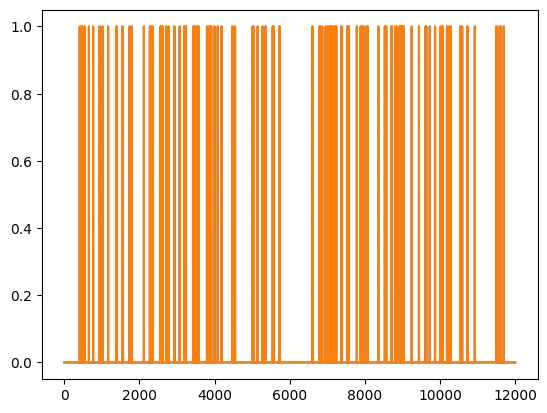

In [94]:
plt.plot(Sbool[0])
plt.plot(Sbool[1])


In [96]:
from scipy.ndimage import gaussian_filter1d
import numpy as np

S = np.zeros([len(Sbool),len(Sbool[0])])

sigma = 1

for i in range(len(Sbool)):

    S[i,np.where(Sbool[i]==1)[0]] = 1
    S[i,np.where((S[1:]-S[:-1])==1)[0]] = 0.5
    S[i,np.where((S[1:]-S[:-1])==-1)[0]+1] = 0.5

    S[i] = gaussian_filter1d(S[i],sigma)
    
cor = np.corrcoef(S[0],S[1])[0,1]

print(cor)

0.9986775220954062


In [118]:

# input stimulus (NetStim) parameters
isi=60*ms         # mean interspike time interval
num=10            # average number of spikes
start=1*ms        # stimulus start time
stop=tmax*ms      # simulation stop time
noise=1         # noise parameter (must be a value from 0 to 1)

seeds=np.random.randint(10000, size=numNoiseInputs)


In [119]:
#BACKGROUND NOISE
# create synapses
synapses = [createSynapse(dendIdx[i], loc=loc, tau=tau[i], e=ee[i]) for i in range(numNoiseInputs)]

# create inputs
stimulations = [createStim(isi=isi, num=num, start=start, noise=noise, seed=seeds[i]) for i in range(numNoiseInputs)]

# connect inputs to synapses
connections = [connectStim(synapses[i], stimulations[i], delay=delay, weight=weight) for i in range(numNoiseInputs)]

#SOURCES
# create synapses
synapsesSour = [createSynapse(dendIdxSour[i], loc=loc, tau=tauE, e=0.) for i in range(numSour)]

# connect inputs to synapses
connectionsSour = [connectStim(synapsesSour[i], stimulationsCorr[i], delay=delay, weight=weight) for i in range(numSour)]


In [120]:
# prepare output variable
recordings = {'soma': h.Vector(),
              'input': [h.Vector() for i in range(numSour)],
              'inputTime': [h.Vector() for i in range(numSour)],
              'dendrite': [h.Vector() for i in range(numSour)],
              'synapse': [h.Vector() for i in range(numSour)],
              'time': h.Vector()}

# set up recordings
recordings['soma'].record(Soma[0](0.5)._ref_v) # soma membrane potential
recordings['time'].record(h._ref_t) # time steps

for i, dend0 in enumerate(dendIdxSour):
    recordings['dendrite'][i].record(dend[dend0](0.5)._ref_v)
    recordings['synapse'][i].record(synapsesSour[i]._ref_i)
    connectionsSour[i].record(recordings['inputTime'][i], recordings['input'][i])


In [121]:
tmax

12000

In [122]:
h.finitialize(-65 * mV)

h.continuerun(tmax)


0.0

In [123]:
# convert outputs into numpy arrays
for k,v in recordings.items():
    if k=='soma' or k=='time':
        recordings[k] = np.array(list(recordings[k]))
    else:
        recordings[k] = [np.array(list(recordings[k][i])) for i in range(len(recordings[k]))]


In [124]:
ini = 2000


/tmp/ipykernel_3851/1690088330.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('winter')


Text(0, 0.5, 'input id')

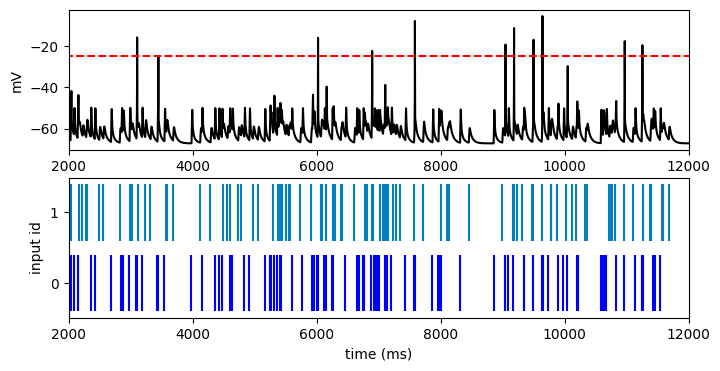

In [125]:
fig,ax = pyplot.subplots(2,1,figsize=(8,4)) # Default figsize is (8,6)

soma_plot = ax[0].plot(recordings["time"], recordings["soma"], color='black')

thres = -25

ax[0].hlines(thres,0,tmax,color="red",linestyle='dashed')

ax[0].set_xlim(ini, tmax)
ax[0].set_xlabel('time (ms)')
ax[0].set_ylabel('mV')

cmap = cm.get_cmap('winter')
spacing = cmap.N//numSour

colours = cmap(np.arange(0, cmap.N, spacing))
    
# rasterplot with input stimuli
for i in range(2):
    ax[1].vlines(recordings['inputTime'][i], i-0.4, i+0.4, colors=colours[i])  

ax[1].set_yticks(range(len(recordings['input'])))
ax[1].set_xlim(ini, tmax)
ax[1].set_xlabel('time (ms)')
ax[1].set_ylabel('input id')


In [126]:

def TimeBining(recordings,bin_size,thres=-30,Timebining=1):
    
    Vsoma = 1*(recordings["soma"] > thres)

    t = recordings["time"]

    dt = np.mean(t[1:]-t[:-1])

    tw = int(np.round(bin_size/dt))
    
    #Equalize input and soma time series
    
    Somabool = np.zeros(len(Sbool[0]),dtype=np.int8)

    for i in range(len(Somabool)-1):

        Somabool[i] = np.sum(Vsoma[tw*i:tw*(i+1)])>0
    
    ######################################
    
    T = int(len(Somabool)/Timebining)

    timeS = np.zeros([3,T],dtype=np.int32)

    SS = [Somabool]
    
    for i in range(len(Sbool)):
        SS.append(Sbool[i])

    for j in range(1+len(Sbool)):

        for i in range(T-1):

            timeS[j,i] = np.int32(1*(np.sum(SS[j][i*Timebining:(i+1)*Timebining])>0))

    return timeS


In [127]:
#Time bin
Ttb = np.arange(0,12,2)

Ttb[0] = 1

for tb in Ttb:

    timeS = TimeBining(recordings,bin_size,-30,tb)

    LabelS = ["Soma","S1","S2"]

    Data = pd.DataFrame()

    cellT = filename.split("/")[1].split(".")[0]

    for i in range(1+len(Sbool)):

        Data[LabelS[i]] = timeS[i,:]

    #save data
    Data.to_csv("PID/Time_serie_"+cellT+"_Simdt_"+str(np.round(dt,4))+"_tbin_"+str(tb)+"_Correlation_"+str(cor)+"_.csv",index=False)
